In [1]:
from langgraph.graph import Graph

In [3]:
from dotenv import load_dotenv
load_dotenv()

True

In [4]:
from langchain_groq import ChatGroq
groq_model=ChatGroq(model="llama-3.1-8b-instant")

from langchain_huggingface import HuggingFaceEmbeddings
embedding_model = HuggingFaceEmbeddings(model_name='sentence-transformers/all-MiniLM-L6-v2')

In [5]:
def LLM(input):
    response = groq_model.invoke(input).content
    return response

def count_words(input):
    token_len = len(input.split())
    response = f"total number of token in the generate output is {token_len}"
    return response

In [6]:
workflow = Graph()
workflow.add_node("My LLM",LLM)
workflow.add_node("Word Counter",count_words)
workflow.add_edge("My LLM","Word Counter")
workflow.set_entry_point("My LLM")
workflow.set_finish_point("Word Counter")

In [ ]:
app = workflow.compile() ## This compiling is like saving graph

In [8]:
app.get_graph()

Graph(nodes={'My LLM': Node(id='My LLM', name='My LLM', data=My LLM(tags=None, recurse=True, explode_args=False, func_accepts_config=False, func_accepts={}), metadata=None), 'Word Counter': Node(id='Word Counter', name='Word Counter', data=Word Counter(tags=None, recurse=True, explode_args=False, func_accepts_config=False, func_accepts={}), metadata=None), '__start__': Node(id='__start__', name='__start__', data=None, metadata=None), '__end__': Node(id='__end__', name='__end__', data=None, metadata=None)}, edges=[Edge(source='__start__', target='My LLM', data=None, conditional=False), Edge(source='My LLM', target='Word Counter', data=None, conditional=False), Edge(source='Word Counter', target='__end__', data=None, conditional=False)])

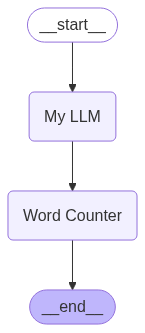

In [9]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png())) 

In [10]:
app.invoke("can you explain me agentic graph briefly in simple words")

'total number of token in the generate output is 203'

In [11]:
for output in app.stream("can you explain me agentic graph briefly in simple words"):
    for key, value in output.items():
        print(key)
        print("\n")
        print(value)
        print("\n\n")
        print("-------")
        

My LLM


An Agentic Graph is a concept in artificial intelligence (AI) and cognitive science that represents a complex network of relationships between different components of a system. Think of it like a map of a city, where roads (edges) connect different neighborhoods (nodes).

In the context of AI, an Agentic Graph typically includes:

1. **Nodes**: Representing individual agents or entities, such as humans, robots, or software programs.
2. **Edges**: Representing relationships or interactions between these nodes, like communication, cooperation, or competition.

The Agentic Graph helps researchers and developers understand how these agents interact and influence each other, leading to complex behaviors and emergent properties. It's like trying to predict traffic patterns in a city by mapping out the roads and intersections.

By visualizing and analyzing the Agentic Graph, researchers can:

* Identify key nodes and edges that drive the system's behavior
* Predict how changes in one

In [46]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain_community.document_loaders import TextLoader, DirectoryLoader
from langchain_community.vectorstores import Chroma
from langchain.text_splitter import RecursiveCharacterTextSplitter

In [16]:
!pwd

/Users/mukulagarwal/Desktop/Projects/langchain


In [23]:
loader=DirectoryLoader("/Users/mukulagarwal/Desktop/Projects/langchain",glob="./*.txt",loader_cls=TextLoader)
docs=loader.load()
text_splitter=RecursiveCharacterTextSplitter(
    chunk_size=250,
    chunk_overlap=25
)
new_docs = text_splitter.split_documents(documents=docs)
doc_strings = [doc.page_content for doc in new_docs]

In [24]:
new_docs

[Document(metadata={'source': '/Users/mukulagarwal/Desktop/Projects/langchain/file.txt'}, page_content='Google opens up its AI language model PaLM to challenge OpenAI and GPT-3 Google \noffers developers access to one of its most advanced AI language models: PaLM. The search'),
 Document(metadata={'source': '/Users/mukulagarwal/Desktop/Projects/langchain/file.txt'}, page_content='giant is launching an API for PaLM alongside a number of AI enterprise tools it says will \nhelp businesses generate text, images, code, videos, audio, and more from simple natural \nlanguage prompts.'),
 Document(metadata={'source': '/Users/mukulagarwal/Desktop/Projects/langchain/file.txt'}, page_content="PaLM is a large language model, or LLM, similar to the GPT series created \nby OpenAI or Meta's LLaMA family of models. Google first announced PaLM in April 2022. Like"),
 Document(metadata={'source': '/Users/mukulagarwal/Desktop/Projects/langchain/file.txt'}, page_content='other LLMs, PaLM is a flexible sys

In [26]:
db = Chroma.from_documents(new_docs, embedding_model)

retriever = db.as_retriever(search_kwargs={"k": 3})

In [27]:
query = "Tell me about India's Industrial Growth?"
docs = retriever.get_relevant_documents(query)
print(docs[0].metadata)
print(docs[0].page_content)

/var/folders/9d/v_vmnb4s20xddx4_8tgtprrh0000gn/T/ipykernel_52358/258206766.py:2: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  docs = retriever.get_relevant_documents(query)


{'source': '/Users/mukulagarwal/Desktop/Projects/langchain/file.txt'}
giant is launching an API for PaLM alongside a number of AI enterprise tools it says will 
help businesses generate text, images, code, videos, audio, and more from simple natural 
language prompts.


In [33]:
AgentState = {}
AgentState['messages'] = []
AgentState['messages'].append("hi")
AgentState['messages'].append("how are you")

AgentState

{'messages': ['hi', 'how are you']}

In [41]:
def function_1(AgentState):
    message=AgentState["messages"]
    
    question=message[-1]
    
    complete_prompt="Your task is to provide only the brief answer based on the user query. \
        Don't include too much reasoning. Following is the user query: " + question
    
    response = groq_model.invoke(complete_prompt)
    
    AgentState['messages'].append(response.content) # appending LLM call response to the AgentState
    
    return AgentState
   
def function_2(AgentState):
    messages = AgentState['messages']
    
    question = messages[0] ## Fetching the user question
    
    template = """Answer the question based only on the following context:
    {context}

    Question: {question}
    """
    prompt = ChatPromptTemplate.from_template(template)

    retrieval_chain = (
        {"context": retriever, "question": RunnablePassthrough()}
        | prompt
        | groq_model
        | StrOutputParser()
        )
    result = retrieval_chain.invoke(question)
    return result

In [42]:
workflow = Graph()
workflow.add_node("LLM",function_1)
workflow.add_node("RAG_tool",function_2)
workflow.add_edge("LLM","RAG_tool")
workflow.set_entry_point("LLM")
workflow.set_finish_point("RAG_tool")
app2=workflow.compile()

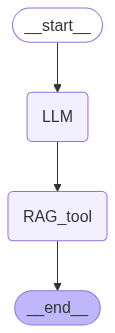

In [32]:
display(Image(app2.get_graph().draw_mermaid_png())) 

In [43]:
app2.invoke({"messages":["What is Google plan on competiting with OpenAI ?"]})

"Google's plan is to compete with OpenAI using its AI language model PaLM, by offering developers access to it through an API, and providing a range of AI enterprise tools."

In [45]:
for output in app2.stream({"messages":["What is Google plan on competiting with OpenAI ?"]}):
    for key,value in output.items():
        print(f"here is output from {key}")
        print("_______")
        print(value)
        print("\n")

here is output from LLM
_______
{'messages': ['What is Google plan on competiting with OpenAI ?', "Google's plan to compete with OpenAI is through its AI subsidiary, DeepMind, and its large language model, Bard."]}


here is output from RAG_tool
_______
Google is planning to compete with OpenAI by offering developers access to one of its most advanced AI language models, PaLM.




State-Graph

In [47]:
loader=TextLoader("/Users/mukulagarwal/Desktop/Projects/langchain/japan.txt")
docs=loader.load()
text_splitter=RecursiveCharacterTextSplitter(
    chunk_size=100,
    chunk_overlap=50
)
new_docs = text_splitter.split_documents(documents=docs)
doc_strings = [doc.page_content for doc in new_docs]

In [48]:
new_docs

[Document(metadata={'source': '/Users/mukulagarwal/Desktop/Projects/langchain/japan.txt'}, page_content='Industrial revival hope for Japan'),
 Document(metadata={'source': '/Users/mukulagarwal/Desktop/Projects/langchain/japan.txt'}, page_content="Japanese industry is growing faster than expected, boosting hopes that the country's retreat back"),
 Document(metadata={'source': '/Users/mukulagarwal/Desktop/Projects/langchain/japan.txt'}, page_content="boosting hopes that the country's retreat back into recession is over."),
 Document(metadata={'source': '/Users/mukulagarwal/Desktop/Projects/langchain/japan.txt'}, page_content='Industrial output rose 2.1% - adjusted for the time of year - in January from a month earlier. At'),
 Document(metadata={'source': '/Users/mukulagarwal/Desktop/Projects/langchain/japan.txt'}, page_content='of year - in January from a month earlier. At the same time, retail sales picked up faster than at'),
 Document(metadata={'source': '/Users/mukulagarwal/Desktop/P

In [59]:
db = Chroma.from_documents(new_docs, embedding_model)

retriever = db.as_retriever(search_kwargs={"k": 3})

In [60]:
query = "Tell me about India's Industrial Growth?"
docs = retriever.get_relevant_documents(query)
print(docs[0].metadata)
print(docs[0].page_content)

{'source': '/Users/mukulagarwal/Desktop/Projects/langchain/japan.txt'}
growth in sectors like apparel and household electronics.


In [61]:
from typing import TypedDict, Annotated,Sequence
import operator
from langchain_core.messages import BaseMessage, HumanMessage,AIMessage,SystemMessage
from langchain.prompts import PromptTemplate
from langchain.output_parsers import PydanticOutputParser

In [58]:
class AgentState(TypedDict):
    messages:Annotated[Sequence[BaseMessage],operator.add]
    
state = {'messages':[HumanMessage(content="hi there")]}
state

{'messages': [HumanMessage(content='hi there', additional_kwargs={}, response_metadata={})]}

In [62]:
from pydantic import BaseModel, Field
class TopicSelectionParser(BaseModel):
    Topic:str=Field(description="selected topic")
    Reasoning:str=Field(description="reasoning behind the topic")
    
parser=PydanticOutputParser(pydantic_object=TopicSelectionParser)
print(parser.get_format_instructions())

The output should be formatted as a JSON instance that conforms to the JSON schema below.

As an example, for the schema {"properties": {"foo": {"title": "Foo", "description": "a list of strings", "type": "array", "items": {"type": "string"}}}, "required": ["foo"]}
the object {"foo": ["bar", "baz"]} is a well-formatted instance of the schema. The object {"properties": {"foo": ["bar", "baz"]}} is not well-formatted.

Here is the output schema:
```
{"properties": {"Topic": {"description": "selected topic", "title": "Topic", "type": "string"}, "Reasoning": {"description": "reasoning behind the topic", "title": "Reasoning", "type": "string"}}, "required": ["Topic", "Reasoning"]}
```


In [65]:
def function_1(state:AgentState):
    
    message=state["messages"]
    
    question=message[-1] 
    
    print("***********here is my question********")
    print(question)
    
    template="""
    Your task is to classify the given user query into one of the following categories: [Japan, Not Related]. 
    Only respond with the category name plus reasoning for it and nothing else.

    User query: {question}
    
    {format_instructions}
    """
    
    prompt = PromptTemplate(template=template,
                            input_variables=["question"],
                            partial_variables={"format_instructions" : parser.get_format_instructions()}
                            )
    
    chain =prompt | groq_model | parser
    
    response = chain.invoke({"question":question,"format_instructions" : parser.get_format_instructions() })
    
    print("***********my response********")
    print(response)
    
    return {"messages":[response.Topic]}

In [66]:
state={"messages":["tell me about the japan's industrial growth?"]}
function_1(state)

***********here is my question********
tell me about the japan's industrial growth?
***********my response********
Topic='Japan' Reasoning="The query asks about Japan's industrial growth, indicating a topic related to Japan."


{'messages': ['Japan']}

In [67]:
def router(state:AgentState):
    print("***********entering into router********")
    print("*********my state from router********")
    print(state)
    
    message=state["messages"]
    
    last_message=message[-1]
    
    print("***********last message********")    
    print(last_message)
    
    if "Japan" in last_message:
        return "RAG Call"
    else:
        return "Simple LLM Call"

In [70]:
def function_2(state:AgentState):
    print("*********my state from function_2(rag)********")
    print(state)
    
    
    print('-> Calling RAG ->')
    
    messages = state['messages']
    
    question = messages[0] ## Fetching the user question
    
    print(question)

    template = """Answer the question based only on the following context:
    {context}

    Question: {question}
    """
    prompt = ChatPromptTemplate.from_template(template)
    
    print(prompt)

    retrieval_chain = (
        {"context": retriever, "question": RunnablePassthrough()}
        | prompt
        | groq_model
        | StrOutputParser()
        )
    result = retrieval_chain.invoke(question)
    response={"messages": [result]}
    print("*********my state from function_2(rag)********")
    print(state)
    return response

In [72]:
def function_3(state:AgentState):
    print('-> Calling LLM ->')

    messages = state['messages']
    
    question = messages[0] ## Fetching the user question

    # Normal LLM call
    complete_query = "Answer the follow question with your knowledge of the real world. Following is the user question: " + question
    response = groq_model.invoke(complete_query)
    response={"messages": [response.content]}
    print("*********my state from function_3(LLM)********")
    print(state)
    return response

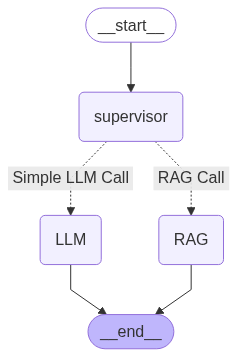

In [73]:
from langgraph.graph import StateGraph, END
workflow=StateGraph(AgentState)
workflow.add_node("supervisor",function_1)
workflow.add_node("RAG",function_2)
workflow.add_node("LLM",function_3)
workflow.set_entry_point("supervisor")
workflow.add_conditional_edges(
    "supervisor",
    router,
    {
        "RAG Call": "RAG",
        "Simple LLM Call": "LLM"
    },
    
)
workflow.add_edge("RAG",END)
workflow.add_edge("LLM",END)
app=workflow.compile()
display(Image(app.get_graph().draw_mermaid_png()))

In [74]:
response=app.invoke({"messages":["can you tell me about the japan industrial growth with GDP?"]})

***********here is my question********
can you tell me about the japan industrial growth with GDP?
***********my response********
Topic='Japan' Reasoning="The query is about Japan's industrial growth and GDP, indicating a focus on Japanese economic data."
***********entering into router********
*********my state from router********
{'messages': ['can you tell me about the japan industrial growth with GDP?', 'Japan']}
***********last message********
Japan
*********my state from function_2(rag)********
{'messages': ['can you tell me about the japan industrial growth with GDP?', 'Japan']}
-> Calling RAG ->
can you tell me about the japan industrial growth with GDP?
input_variables=['context', 'question'] input_types={} partial_variables={} messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['context', 'question'], input_types={}, partial_variables={}, template='Answer the question based only on the following context:\n    {context}\n\n    Question: {question}\n    

In [77]:
print(response['messages'][-1])

Based on the provided context, here's the information about Japan's industrial growth with GDP mentioned:

Japan's last four-year GDP is necessary to sustain growth. Overall, Japan's economy appears to be on a path of gradual growth. As of mid-2025, Japan's economy is experiencing a nuanced recovery characterized by moderate growth.

This suggests that Japan's GDP has been growing gradually over the last four years and is currently experiencing a moderate recovery as of mid-2025.
